## Post-stack inversion with proximal solvers - Volve

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import segyio

from scipy.signal import filtfilt
from scipy.linalg import solve
from scipy.sparse.linalg import lsqr
from scipy.ndimage import gaussian_filter
from scipy.interpolate import RegularGridInterpolator
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.cm as cm

from pylops.basicoperators import *
from pylops.signalprocessing import *
from pylops.utils.wavelets import *
from pylops.avo.poststack import *
from pylops.optimization.sparsity import *

from pyproximal.proximal import *
from pyproximal import ProxOperator
from pyproximal.optimization.primal import *
from pyproximal.optimization.primaldual import *
from pyproximal.optimization.bregman import *
from pyproximal.optimization.segmentation import *

In [2]:
def vint2vrms(vint, t):
    nt = t.size
    dt = np.diff(t)
    vrms = np.zeros(nt)
    vrms[:-1] = np.cumsum(dt * (vint[:-1]**2));
    vrms[:-1] = np.sqrt(vrms[:-1] / t[:-1]-t[0])
    vrms[-1] = vrms[-2]
    return vrms

def vrms2vint(vrms, t):
    nt = t.size
    i1 = np.arange(0, nt-1)
    i2 = np.arange(1, nt)
    vint = np.zeros(nt)
    vrms2 = vrms ** 2
    vint[i1]= np.sqrt((vrms2[i2]*(t[i2] - t[0]) - vrms2[i1]*(t[i1] - t[0])) / (t[i2] - t[i1]))

    #find and process non-physical ones
    inp = np.where(vint<0);
    if len(inp):
        vint[inp] = np.nan
    return vint

In [3]:
os.environ['NUMBA_NUM_THREADS']

'4'

## Load data

In [4]:
f = np.load('/Users/matteoravasi/Desktop/Statoil/2020/Project/SegmentationPostStack/SegmentationPostStack/Volve2dline.npz',
            allow_pickle=True)

In [5]:
f.files

['il_seis',
 'xl_seis',
 't_seis',
 'il_vel',
 'xl_vel',
 'z_vel',
 'il_vrms',
 'xl_vrms',
 't_vrms',
 'seismict_il',
 'seismict_xl',
 'vel_il',
 'vel_xl',
 'vrms_il',
 'vrms_xl',
 'horizons_il',
 'horizons_xl',
 'well_tvdss',
 'well_ai']

In [6]:
il_seis, xl_seis, t_seis = f['il_seis'], f['xl_seis'], f['t_seis']
il_vel, xl_vel, z_vel = f['il_vel'], f['xl_vel'], f['z_vel']
il_vrms, xl_vrms, t_vrms = f['il_vrms'], f['xl_vrms'], f['t_vrms']

vel_il = f['vel_il']
vel_xl = f['vel_xl']
vrms_il = f['vrms_il']
vrms_xl = f['vrms_xl']

seismic_il = f['seismict_il']
seismic_xl = f['seismict_xl']

horizons_il = f['horizons_il'][()]
horizons_xl = f['horizons_xl'][()]

well_tvdss = f['well_tvdss']
well_ai = f['well_ai']

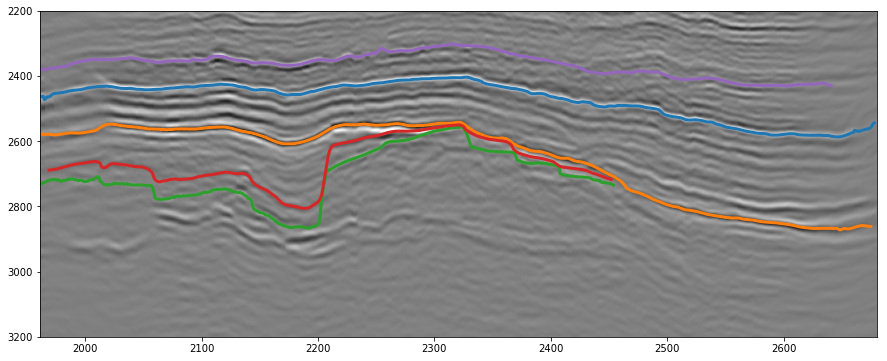

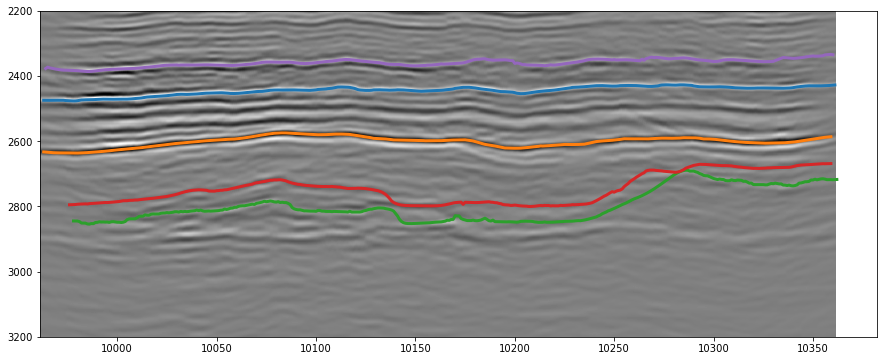

In [7]:
plt.figure(figsize=(15, 6))
plt.imshow(seismic_il.T, cmap='gray', vmin=-10, vmax=10, interpolation='sinc',
          extent=(xl_seis[0], xl_seis[-1], t_seis[-1], t_seis[0]))
for ihor, horname in enumerate(horizons_il.keys()):
    plt.plot(horizons_il[horname][0], horizons_il[horname][1], lw=3)
plt.axis('tight')
plt.ylim(3200,2200);

plt.figure(figsize=(15, 6))
plt.imshow(seismic_xl.T, cmap='gray', vmin=-10, vmax=10, interpolation='sinc',
          extent=(il_seis[0], il_seis[-1], t_seis[-1], t_seis[0]))
for ihor, horname in enumerate(horizons_il.keys()):
    plt.plot(horizons_xl[horname][0], horizons_xl[horname][1], lw=3)
plt.axis('tight')
plt.ylim(3200,2200);

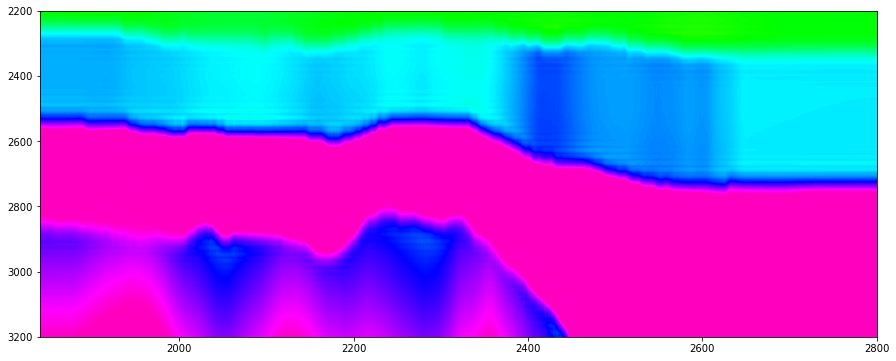

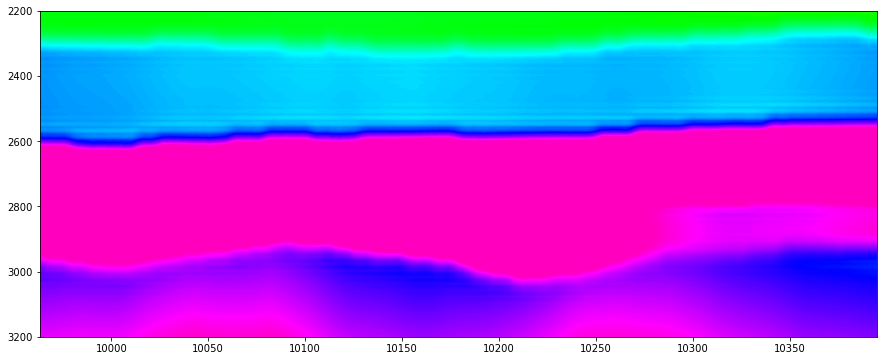

In [8]:
plt.figure(figsize=(15, 6))
plt.imshow(vel_il.T, cmap='gist_rainbow', vmin=1000, vmax=4000, interpolation='sinc',
          extent=(xl_vel[0], xl_vel[-1], z_vel[-1], z_vel[0]))
plt.axis('tight')
plt.ylim(3200,2200);

plt.figure(figsize=(15, 6))
plt.imshow(vel_xl.T, cmap='gist_rainbow', vmin=1000, vmax=4000, interpolation='sinc',
           extent=(il_vel[0], il_vel[-1], z_vel[-1], z_vel[0]))
plt.axis('tight')
plt.ylim(3200,2200);

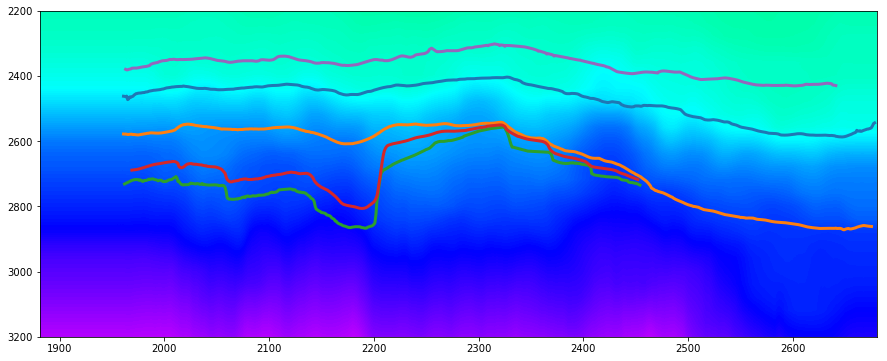

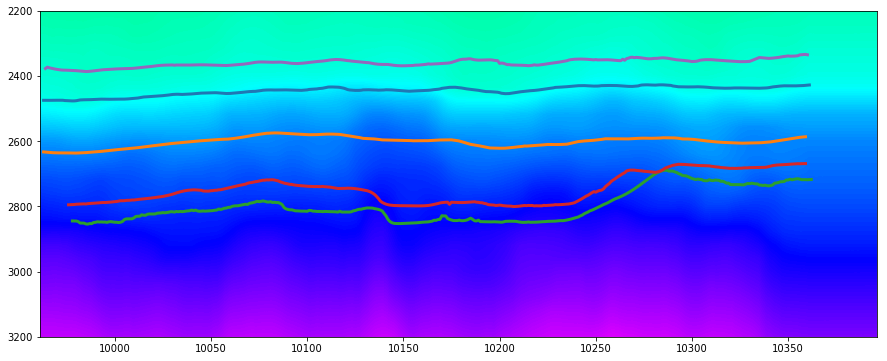

In [9]:
plt.figure(figsize=(15, 6))
plt.imshow(vrms_il.T, cmap='gist_rainbow', vmin=1000, vmax=3000, interpolation='sinc',
          extent=(xl_vrms[0], xl_vrms[-1], t_vrms[-1], t_vrms[0]))
for ihor, horname in enumerate(horizons_il.keys()):
    plt.plot(horizons_il[horname][0], horizons_il[horname][1], lw=3)
plt.axis('tight')
plt.ylim(3200,2200);

plt.figure(figsize=(15, 6))
plt.imshow(vrms_xl.T, cmap='gist_rainbow', vmin=1000, vmax=3000, interpolation='sinc',
          extent=(il_vrms[0], il_vrms[-1], t_vrms[-1], t_vrms[0]))
for ihor, horname in enumerate(horizons_il.keys()):
    plt.plot(horizons_xl[horname][0], horizons_xl[horname][1], lw=3)
plt.axis('tight')
plt.ylim(3200,2200);

## Estimate wavelet

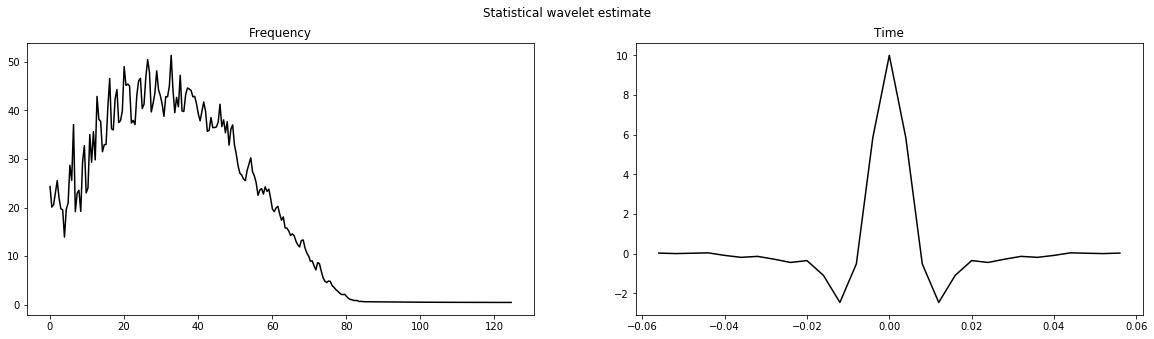

In [10]:
nt_wav = 15 # number of samples of statistical wavelet
nfft = 512 # number of samples of FFT
wav_scaling = 1e1
dt = t_seis[1] - t_seis[0]

# Wavelet time axis
t_wav = np.arange(nt_wav) * (dt/1000)
t_wav = np.concatenate((np.flipud(-t_wav[1:]), t_wav), axis=0)

# Estimate wavelet spectrum
wav_est_fft = np.mean(np.abs(np.fft.fft(seismic_il, nfft, axis=-1)), axis=0)
fwest = np.fft.fftfreq(nfft, d=dt/1000)

# Create wavelet in time
wav_est = np.real(np.fft.ifft(wav_est_fft)[:nt_wav])
wav_est = np.concatenate((np.flipud(wav_est[1:]), wav_est), axis=0)
wav_est = wav_est / wav_est.max()
wav_est *= wav_scaling

# Display wavelet
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
fig.suptitle('Statistical wavelet estimate')
axs[0].plot(fwest[:nfft//2], wav_est_fft[:nfft//2], 'k')
axs[0].set_title('Frequency')
axs[1].plot(t_wav, wav_est, 'k')
axs[1].set_title('Time');

## Compute interval velocities from RMS

Given that we have access to only RMS velocities in time, we need to estimate interval velocities from them

In [11]:
vint_il = np.zeros_like(vrms_il)
for ixl in range(len(xl_vrms)):
    vint_il[ixl] = vrms2vint(vrms_il[ixl], t_vrms / 1000)
vint_il = gaussian_filter(vint_il, sigma=30)

vint_xl = np.zeros_like(vrms_xl)
for iil in range(len(il_vrms)):
    vint_xl[iil] = vrms2vint(vrms_xl[iil], t_vrms / 1000)
vint_xl = gaussian_filter(vint_xl, sigma=30)

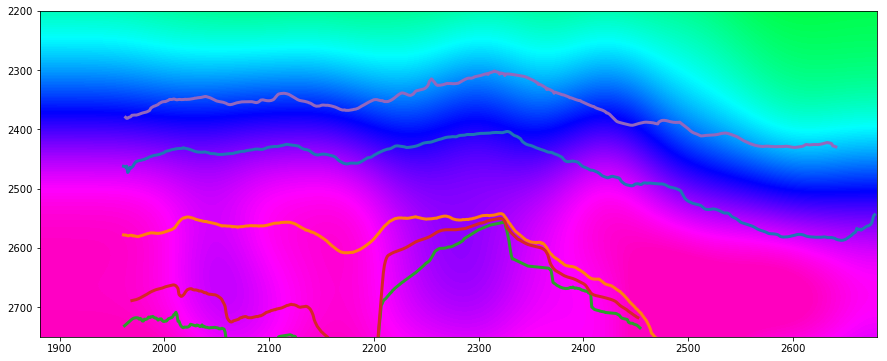

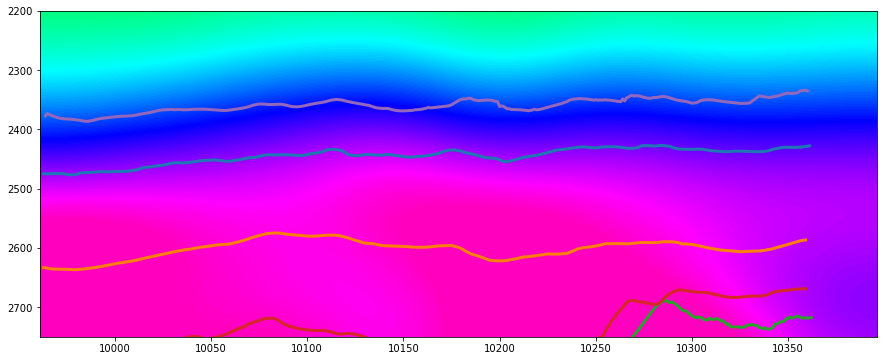

In [12]:
plt.figure(figsize=(15, 6))
plt.imshow(vint_il.T, cmap='gist_rainbow', vmin=1000, vmax=4000, interpolation='sinc',
          extent=(xl_vrms[0], xl_vrms[-1], t_vrms[-1], t_vrms[0]))
for ihor, horname in enumerate(horizons_il.keys()):
    plt.plot(horizons_il[horname][0], horizons_il[horname][1], lw=3)
plt.axis('tight')
plt.ylim(2750,2200);

plt.figure(figsize=(15, 6))
plt.imshow(vint_xl.T, cmap='gist_rainbow', vmin=1000, vmax=4000, interpolation='sinc',
          extent=(il_vrms[0], il_vrms[-1], t_vrms[-1], t_vrms[0]))
for ihor, horname in enumerate(horizons_il.keys()):
    plt.plot(horizons_xl[horname][0], horizons_xl[horname][1], lw=3)
plt.axis('tight')
plt.ylim(2750,2200);

We now regrid the RMS velocities to the same grid as our data

In [13]:
IL, T = np.meshgrid(il_seis, t_seis, indexing='ij')

vinterp = RegularGridInterpolator((il_vrms, t_vrms), vint_xl, bounds_error=False, fill_value=0)
vint_xl = vinterp(np.vstack((IL.ravel(), T.ravel())).T)
vint_xl = vint_xl.reshape(seismic_xl.shape)

In [14]:
XL, T = np.meshgrid(xl_seis, t_seis, indexing='ij')

vinterp = RegularGridInterpolator((xl_vrms, t_vrms), vint_il, bounds_error=False, fill_value=0)
vint_il = vinterp(np.vstack((XL.ravel(), T.ravel())).T)
vint_il = vint_il.reshape(seismic_il.shape)

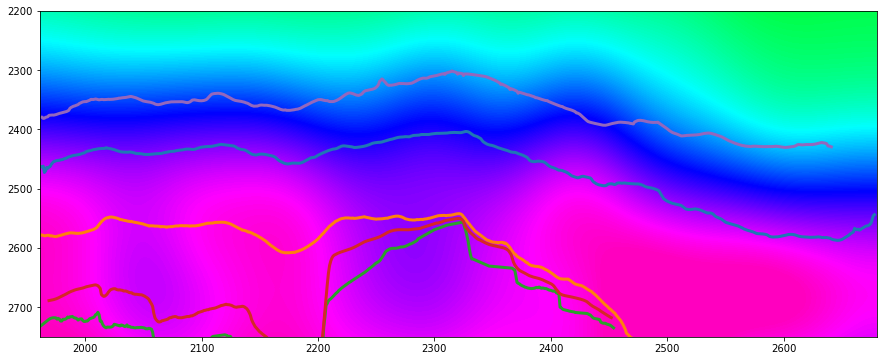

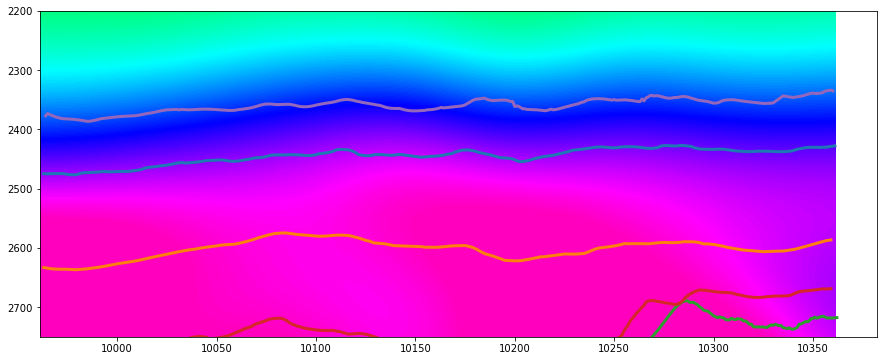

In [15]:
plt.figure(figsize=(15, 6))
plt.imshow(vint_il.T, cmap='gist_rainbow', vmin=1000, vmax=4000, interpolation='sinc',
          extent=(xl_seis[0], xl_seis[-1], t_seis[-1], t_seis[0]))
for ihor, horname in enumerate(horizons_il.keys()):
    plt.plot(horizons_il[horname][0], horizons_il[horname][1], lw=3)
plt.axis('tight')
plt.ylim(2750,2200);

plt.figure(figsize=(15, 6))
plt.imshow(vint_xl.T, cmap='gist_rainbow', vmin=1000, vmax=4000, interpolation='sinc',
          extent=(il_seis[0], il_seis[-1], t_seis[-1], t_seis[0]))
for ihor, horname in enumerate(horizons_il.keys()):
    plt.plot(horizons_xl[horname][0], horizons_xl[horname][1], lw=3)
plt.axis('tight')
plt.ylim(2750,2200);

Convert well logs to time

In [16]:
ilwell = 10091
xlwell = 2146

iilwell = np.argmin(np.abs(il_seis - ilwell))
ixlwell = np.argmin(np.abs(xl_seis - xlwell))
vint_xlwell = vint_xl[iilwell]

z_time2depth = np.cumsum(vint_xlwell * (dt / 2000.))
well_ai_t = np.interp(z_time2depth, well_tvdss, well_ai)

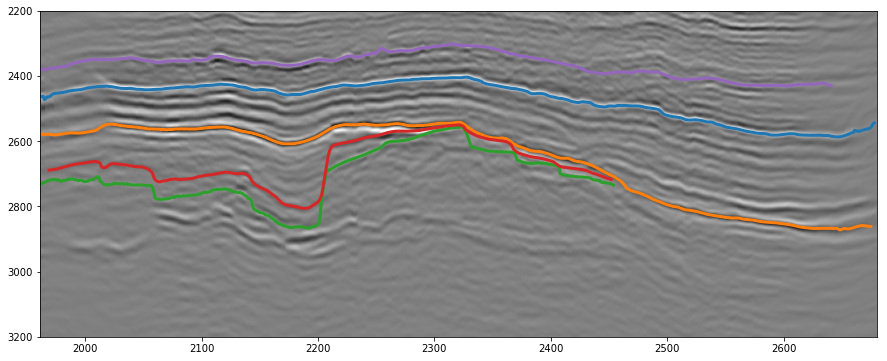

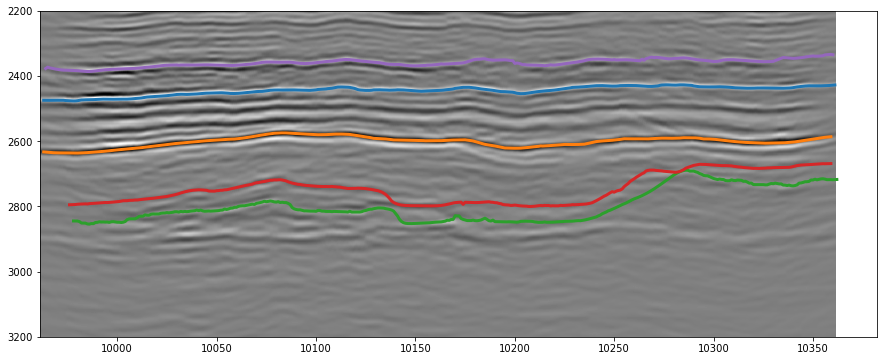

In [17]:
plt.figure(figsize=(15, 6))
plt.imshow(seismic_il.T, cmap='gray', vmin=-10, vmax=10, interpolation='sinc',
          extent=(xl_seis[0], xl_seis[-1], t_seis[-1], t_seis[0]))
for ihor, horname in enumerate(horizons_il.keys()):
    plt.plot(horizons_il[horname][0], horizons_il[horname][1], lw=3)
plt.axis('tight')
plt.ylim(3200,2200);

plt.figure(figsize=(15, 6))
plt.imshow(seismic_xl.T, cmap='gray', vmin=-10, vmax=10, interpolation='sinc',
          extent=(il_seis[0], il_seis[-1], t_seis[-1], t_seis[0]))
for ihor, horname in enumerate(horizons_il.keys()):
    plt.plot(horizons_xl[horname][0], horizons_xl[horname][1], lw=3)
plt.axis('tight')
plt.ylim(3200,2200);

Window data and velocity model to area of interest

In [18]:
tmin, tmax = 2100, 3200
itmin, itmax = int((tmin-t_seis[0])/dt), int((tmax-t_seis[0])/dt)

vint_il, vint_xl = vint_il[:, itmin:itmax], vint_xl[:, itmin:itmax]
seismic_il, seismic_xl = seismic_il[:, itmin:itmax], seismic_xl[:, itmin:itmax]
t_cut = t_seis[itmin:itmax]

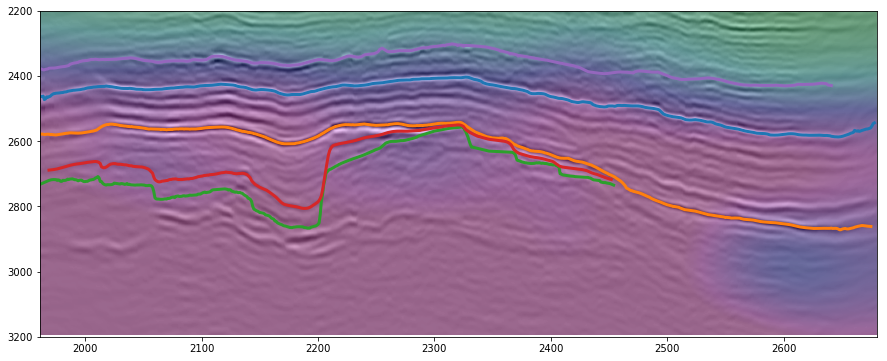

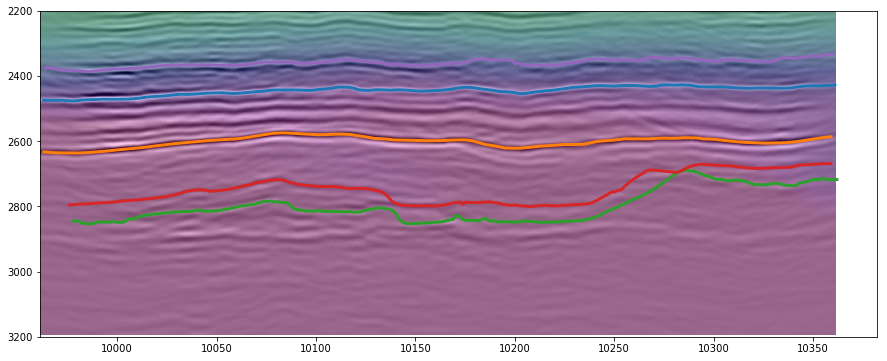

In [19]:
plt.figure(figsize=(15, 6))
plt.imshow(seismic_il.T, cmap='gray', vmin=-10, vmax=10, interpolation='sinc',
          extent=(xl_seis[0], xl_seis[-1], t_cut[-1], t_cut[0]))
plt.imshow(vint_il.T, cmap='gist_rainbow', vmin=1000, vmax=4000, interpolation='sinc', alpha=0.2,
          extent=(xl_seis[0], xl_seis[-1], t_cut[-1], t_cut[0]))
for ihor, horname in enumerate(horizons_il.keys()):
    plt.plot(horizons_il[horname][0], horizons_il[horname][1], lw=3)
plt.axis('tight')
plt.ylim(3200,2200);

plt.figure(figsize=(15, 6))
plt.imshow(seismic_xl.T, cmap='gray', vmin=-10, vmax=10, interpolation='sinc',
          extent=(il_seis[0], il_seis[-1], t_cut[-1], t_cut[0]))
plt.imshow(vint_xl.T, cmap='gist_rainbow', vmin=1000, vmax=4000, interpolation='sinc', alpha=0.2,
          extent=(il_seis[0], il_seis[-1], t_cut[-1], t_cut[0]))

for ihor, horname in enumerate(horizons_il.keys()):
    plt.plot(horizons_xl[horname][0], horizons_xl[horname][1], lw=3)
plt.axis('tight')
plt.ylim(3200,2200);

## 2D Post-stack inversion

Convert background velocities to AI

In [20]:
intercept = -3952.2622879733026
gradient = 3.3952561093488325

ai_xl = np.log(intercept + gradient*vint_xl)
ai_il = np.log(intercept + gradient*vint_il)

In [21]:
nt = itmax - itmin
nil, nxl = il_seis.size, xl_seis.size

Lop = PoststackLinearModelling(wav_est, nt0=nt, spatdims=nil)

In [22]:
dback = Lop*ai_xl.T.ravel()
dback = dback.reshape(nt, nil)

 
LSQR            Least-squares solution of  Ax = b
The matrix A has 220550 rows and 110275 columns
damp = 1.00000000000000e-02   calc_var =        0
atol = 1.00e-08                 conlim = 1.00e+08
btol = 1.00e-08               iter_lim =       50
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   5.559e+02  5.559e+02    1.0e+00  2.5e-02
     1 -2.78129e-02   2.581e+02  2.581e+02    4.6e-01  6.1e-01   1.6e+01  1.0e+00
     2 -4.12680e-02   1.778e+02  1.778e+02    3.2e-01  3.1e-01   2.1e+01  2.2e+00
     3 -4.61981e-02   1.452e+02  1.452e+02    2.6e-01  2.4e-01   2.5e+01  3.5e+00
     4 -5.02611e-02   1.187e+02  1.187e+02    2.1e-01  2.1e-01   2.8e+01  5.3e+00
     5 -4.70120e-02   9.925e+01  9.925e+01    1.8e-01  1.8e-01   3.1e+01  7.3e+00
     6 -3.86653e-02   8.442e+01  8.442e+01    1.5e-01  1.5e-01   3.4e+01  9.3e+00
     7 -3.32862e-02   7.414e+01  7.415e+01    1.3e-01  1.2e-01   3.6e+01  1.1e+01
     8 -3.00600e-02   6.730e+0

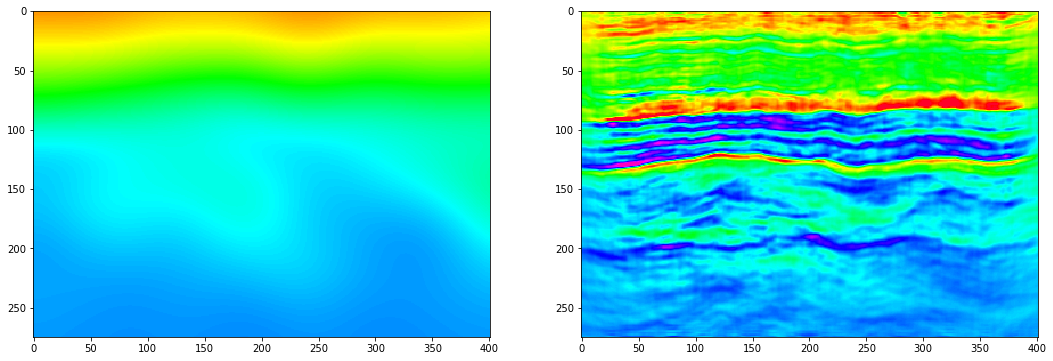

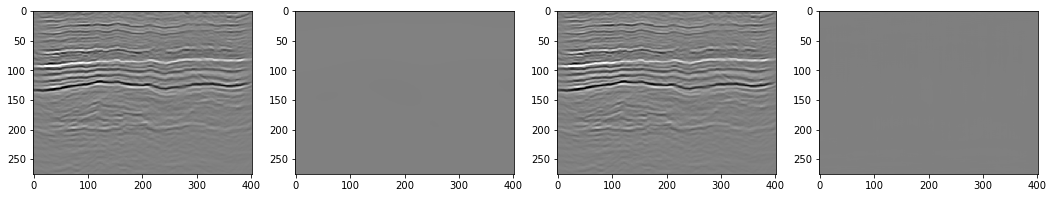

In [23]:
# L2 regularized inversion
Dop = Laplacian(dims=(nt, nil), dtype=Lop.dtype)
minv = RegularizedInversion(Lop, [Dop], seismic_xl.T.ravel(),
                            x0=ai_xl.T.ravel(), epsRs=[0.5], returninfo=False, show=True,
                            **dict(iter_lim=50, damp=1e-2))
dinv = Lop*minv

minv = minv.reshape(nt, nil)
dback = dback.reshape(nt, nil)
dinv = dinv.reshape(nt, nil)

fig, axs = plt.subplots(1, 2, figsize=(18, 6))
axs[0].imshow(ai_xl.T, cmap='gist_rainbow', vmin=8, vmax=10)
axs[0].axis('tight')
axs[1].imshow(minv, cmap='gist_rainbow', vmin=8, vmax=10)
axs[1].axis('tight')

fig, axs = plt.subplots(1, 4, figsize=(18, 3))
axs[0].imshow(seismic_xl.T, cmap='gray', vmin=-10, vmax=10)
axs[0].axis('tight')
axs[1].imshow(dback, cmap='gray', vmin=-10, vmax=10)
axs[1].axis('tight')
axs[2].imshow(dinv, cmap='gray', vmin=-10, vmax=10)
axs[2].axis('tight')
axs[3].imshow(seismic_xl.T-dinv, cmap='gray', vmin=-10, vmax=10)
axs[3].axis('tight');

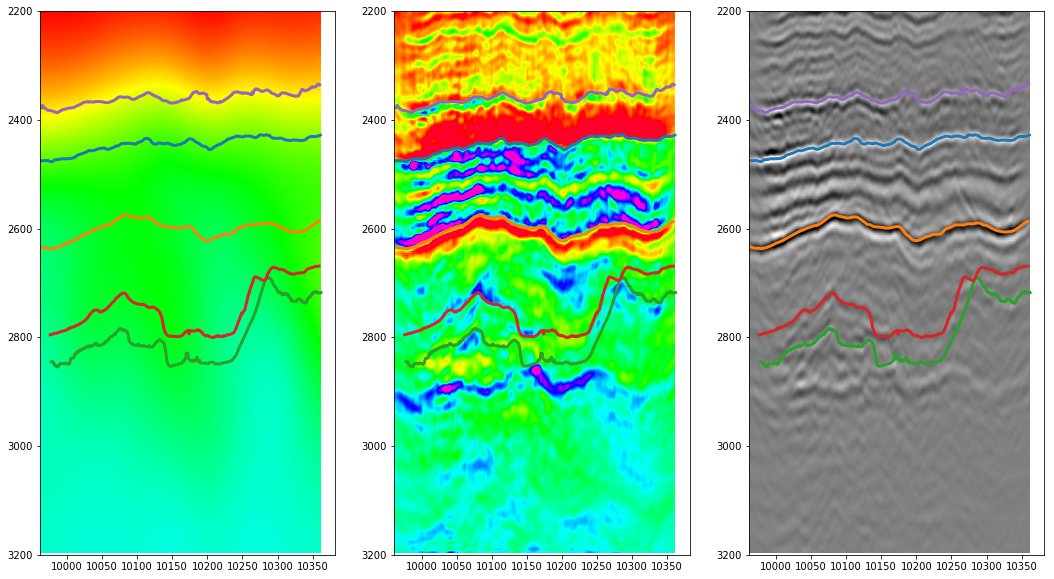

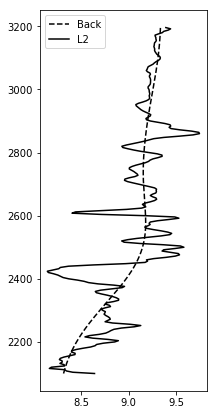

In [24]:
fig, axs = plt.subplots(1, 3, figsize=(18, 10))
axs[0].imshow(np.exp(ai_xl.T), cmap='gist_rainbow', vmin=4000, vmax=17000, interpolation='sinc',
              extent=(il_seis[0], il_seis[-1], t_cut[-1], t_cut[0]))
for ihor, horname in enumerate(horizons_il.keys()):
    axs[0].plot(horizons_xl[horname][0], horizons_xl[horname][1], lw=3)
axs[0].axis('tight')
axs[0].set_ylim(3200,2200);
axs[1].imshow(np.exp(minv), cmap='gist_rainbow', vmin=4000, vmax=17000, interpolation='sinc',
              extent=(il_seis[0], il_seis[-1], t_cut[-1], t_cut[0]))
for ihor, horname in enumerate(horizons_il.keys()):
    axs[1].plot(horizons_xl[horname][0], horizons_xl[horname][1], lw=3)
axs[1].axis('tight')
axs[1].set_ylim(3200,2200);
axs[2].imshow(seismic_xl.T, cmap='gray', vmin=-10, vmax=10, interpolation='sinc',
              extent=(il_seis[0], il_seis[-1], t_cut[-1], t_cut[0]))
for ihor, horname in enumerate(horizons_il.keys()):
    axs[2].plot(horizons_xl[horname][0], horizons_xl[horname][1], lw=3)
axs[2].axis('tight')
axs[2].set_ylim(3200,2200);

plt.figure(figsize=(3, 7))
plt.plot(ai_xl[nil//2], t_cut, '--k', label='Back')
plt.plot(minv[:, nil//2], t_cut, 'k', label='L2')
plt.legend();

Linearized-ADMM
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.L2.L2'>
Proximal operator (g): <class 'pyproximal.proximal.L21.L21'>
Linear operator (A): <class 'pylops.basicoperators.VStack.VStack'>
tau = 1.000000e+00	mu = 1.237500e-01	niter = 100

   Itn       x[0]          f           g       J = f + g
     1   8.22014e+00   1.323e+04   7.002e+01   1.330e+04
     2   8.22323e+00   2.340e+03   6.327e+01   2.403e+03
     3   8.23023e+00   1.242e+03   6.174e+01   1.304e+03
     4   8.23785e+00   9.250e+02   6.122e+01   9.862e+02
     5   8.24354e+00   7.322e+02   6.115e+01   7.933e+02
     6   8.24887e+00   5.948e+02   6.126e+01   6.561e+02
     7   8.25322e+00   4.976e+02   6.141e+01   5.590e+02
     8   8.25707e+00   4.275e+02   6.152e+01   4.890e+02
     9   8.26040e+00   3.757e+02   6.163e+01   4.373e+02
    10   8.26337e+00   3.366e+02   6.172e+01   3.983e+02
    11   8.26597e+00   3.064e+02   6.179e+01   3.682e+02
    2

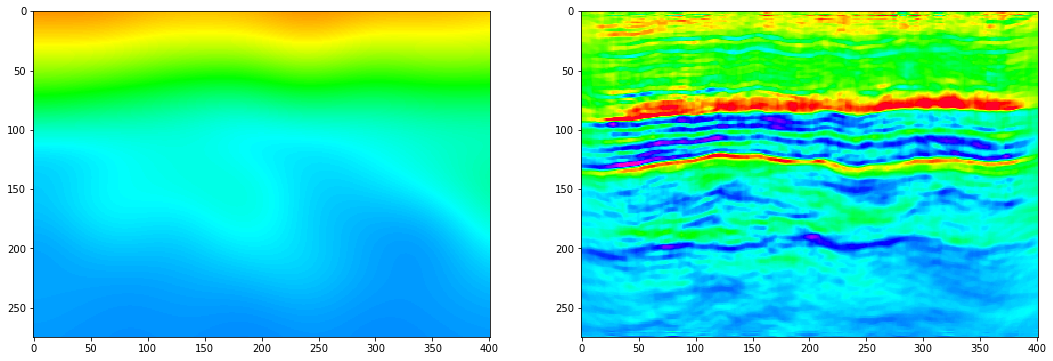

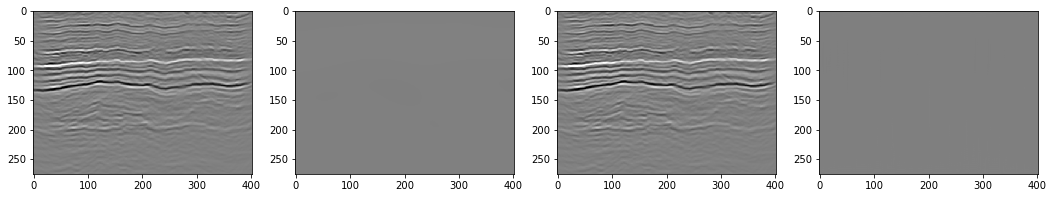

In [25]:
# L-ADMM (Blockiness-promoting inversion with isotropic TV)
sigma=0.01
l1 = L21(ndim=2, sigma=sigma)
l2 = L2(Op=Lop, b=seismic_xl.T.ravel(), niter=30, warm=True)
Dop = Gradient(dims=(nt, nil), edge=True, dtype=Lop.dtype, kind='forward')

L = 8. #np.real((Dop.H*Dop).eigs(neigs=1, which='LM')[0])
tau = 1.
mu = 0.99 * tau / L # optimal mu<=tau/maxeig(Dop^H Dop)

mladmm = LinearizedADMM(l2, l1, Dop, tau=tau, mu=mu, x0=ai_xl.T.ravel(), niter=100, show=True)[0]
dinv = Lop*mladmm

mladmm = mladmm.reshape(nt, nil)
dinv = dinv.reshape(nt, nil)

fig, axs = plt.subplots(1, 2, figsize=(18, 6))
axs[0].imshow(ai_xl.T, cmap='gist_rainbow', vmin=8, vmax=10)
axs[0].axis('tight')
axs[1].imshow(mladmm, cmap='gist_rainbow', vmin=8, vmax=10)
axs[1].axis('tight')

fig, axs = plt.subplots(1, 4, figsize=(18, 3))
axs[0].imshow(seismic_xl.T, cmap='gray', vmin=-10, vmax=10)
axs[0].axis('tight')
axs[1].imshow(dback, cmap='gray', vmin=-10, vmax=10)
axs[1].axis('tight')
axs[2].imshow(dinv, cmap='gray', vmin=-10, vmax=10)
axs[2].axis('tight')
axs[3].imshow(seismic_xl.T-dinv, cmap='gray', vmin=-10, vmax=10)
axs[3].axis('tight');

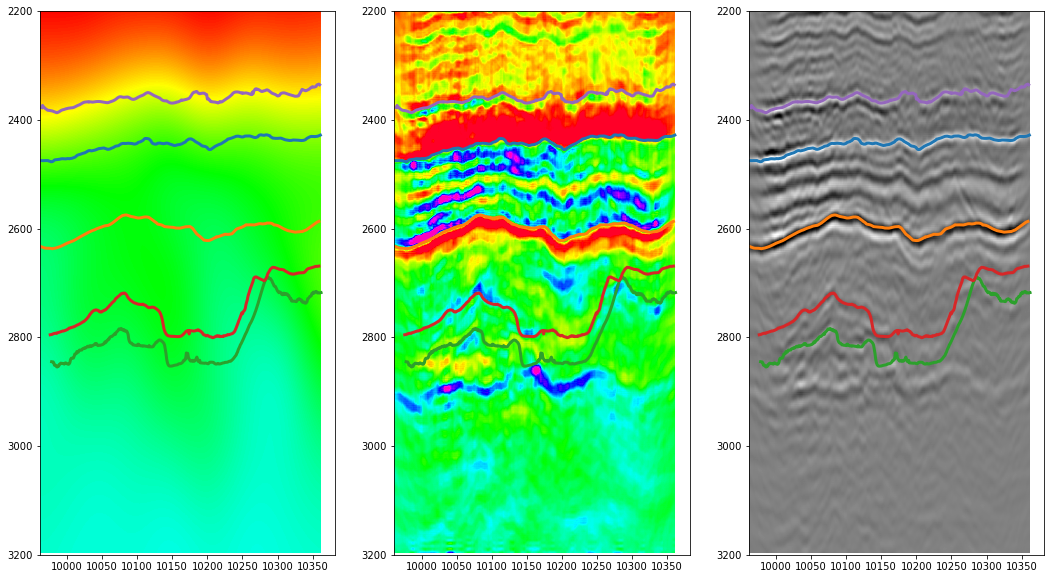

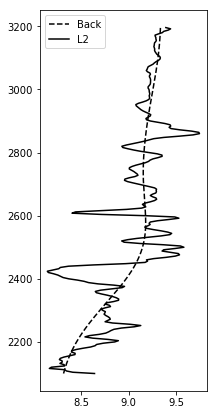

In [26]:
fig, axs = plt.subplots(1, 3, figsize=(18, 10))
axs[0].imshow(np.exp(ai_xl.T), cmap='gist_rainbow', vmin=4000, vmax=17000, interpolation='sinc',
              extent=(il_seis[0], il_seis[-1], t_cut[-1], t_cut[0]))
for ihor, horname in enumerate(horizons_il.keys()):
    axs[0].plot(horizons_xl[horname][0], horizons_xl[horname][1], lw=3)
axs[0].axis('tight')
axs[0].set_ylim(3200,2200);
axs[1].imshow(np.exp(mladmm), cmap='gist_rainbow', vmin=4000, vmax=17000, interpolation='sinc',
              extent=(il_seis[0], il_seis[-1], t_cut[-1], t_cut[0]))
for ihor, horname in enumerate(horizons_il.keys()):
    axs[1].plot(horizons_xl[horname][0], horizons_xl[horname][1], lw=3)
axs[1].axis('tight')
axs[1].set_ylim(3200,2200);
axs[2].imshow(seismic_xl.T, cmap='gray', vmin=-10, vmax=10, interpolation='sinc',
              extent=(il_seis[0], il_seis[-1], t_cut[-1], t_cut[0]))
for ihor, horname in enumerate(horizons_il.keys()):
    axs[2].plot(horizons_xl[horname][0], horizons_xl[horname][1], lw=3)
axs[2].axis('tight')
axs[2].set_ylim(3200,2200);

plt.figure(figsize=(3, 7))
plt.plot(ai_xl[nil//2], t_cut, '--k', label='Back')
plt.plot(minv[:, nil//2], t_cut, 'k', label='L2')
plt.legend();

True
Primal-dual: min_x f(Ax) + x^T z + g(x)
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.L2.L2'>
Proximal operator (g): <class 'pyproximal.proximal.L21.L21'>
Linear operator (A): <class 'pylops.basicoperators.VStack.VStack'>
Additional vector (z): None
tau = 3.535534e-02	mu = 3.535534e+00
theta = 1.00		niter = 100

   Itn       x[0]          f           g       J = f + g
     1   8.23655e+00   9.970e+03   4.798e+02   1.045e+04
     2   8.23673e+00   4.242e+03   5.438e+02   4.786e+03
     3   8.24204e+00   2.858e+03   5.579e+02   3.416e+03
     4   8.24784e+00   2.191e+03   5.631e+02   2.754e+03
     5   8.25308e+00   1.791e+03   5.661e+02   2.357e+03
     6   8.25765e+00   1.522e+03   5.680e+02   2.090e+03
     7   8.26151e+00   1.326e+03   5.691e+02   1.895e+03
     8   8.26474e+00   1.175e+03   5.694e+02   1.744e+03
     9   8.26746e+00   1.054e+03   5.694e+02   1.623e+03
    10   8.26983e+00   9.547e+02   5.692e+02   1

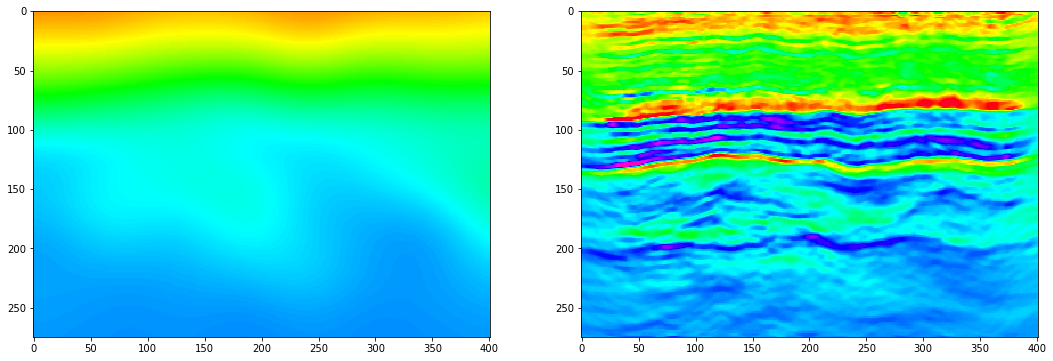

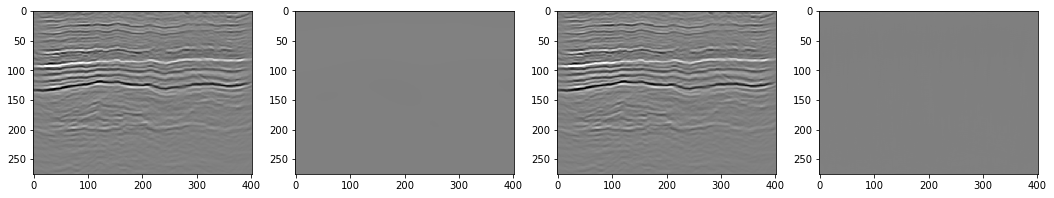

In [27]:
# Primal-dual (Blockiness-promoting inversion with isotropic TV)
sigma = 0.1
l1 = L21(ndim=2, sigma=sigma)
l2 = L2(Op=Lop, b=seismic_xl.T.ravel(), niter=20, warm=True)
Dop = Gradient(dims=(nt, nil), edge=True, dtype=Lop.dtype, kind='forward')

L = 8. # np.real((Dop.H*Dop).eigs(neigs=1, which='LM')[0])
tau = 0.1 / np.sqrt(L)
mu = 10. / np.sqrt(L)
print(tau*mu*L<1)

mpd = PrimalDual(l2, l1, Dop, ai_xl.T.ravel(), tau=tau, mu=mu, theta=1., niter=100, show=True)
dinv = Lop*mpd

mpd = mpd.reshape(nt, nil)
dinv = dinv.reshape(nt, nil)

fig, axs = plt.subplots(1, 2, figsize=(18, 6))
axs[0].imshow(ai_xl.T, cmap='gist_rainbow', vmin=8, vmax=10)
axs[0].axis('tight')
axs[1].imshow(mpd, cmap='gist_rainbow', vmin=8, vmax=10)
axs[1].axis('tight')

fig, axs = plt.subplots(1, 4, figsize=(18, 3))
axs[0].imshow(seismic_xl.T, cmap='gray', vmin=-10, vmax=10)
axs[0].axis('tight')
axs[1].imshow(dback, cmap='gray', vmin=-10, vmax=10)
axs[1].axis('tight')
axs[2].imshow(dinv, cmap='gray', vmin=-10, vmax=10)
axs[2].axis('tight')
axs[3].imshow(seismic_xl.T-dinv, cmap='gray', vmin=-10, vmax=10)
axs[3].axis('tight');

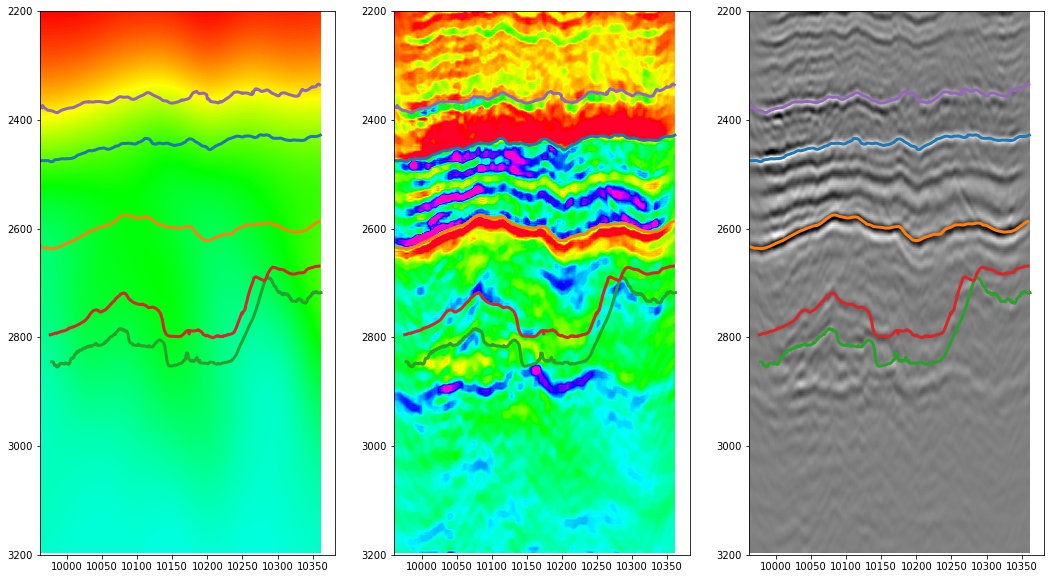

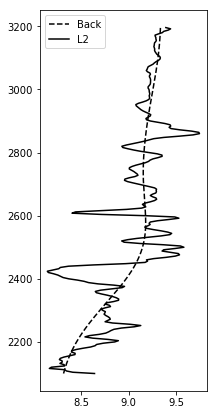

In [28]:
fig, axs = plt.subplots(1, 3, figsize=(18, 10))
axs[0].imshow(np.exp(ai_xl.T), cmap='gist_rainbow', vmin=4000, vmax=17000, interpolation='sinc',
              extent=(il_seis[0], il_seis[-1], t_cut[-1], t_cut[0]))
for ihor, horname in enumerate(horizons_il.keys()):
    axs[0].plot(horizons_xl[horname][0], horizons_xl[horname][1], lw=3)
axs[0].axis('tight')
axs[0].set_ylim(3200,2200);
axs[1].imshow(np.exp(mpd), cmap='gist_rainbow', vmin=4000, vmax=17000, interpolation='sinc',
              extent=(il_seis[0], il_seis[-1], t_cut[-1], t_cut[0]))
for ihor, horname in enumerate(horizons_il.keys()):
    axs[1].plot(horizons_xl[horname][0], horizons_xl[horname][1], lw=3)
axs[1].axis('tight')
axs[1].set_ylim(3200,2200);
axs[2].imshow(seismic_xl.T, cmap='gray', vmin=-10, vmax=10, interpolation='sinc',
              extent=(il_seis[0], il_seis[-1], t_cut[-1], t_cut[0]))
for ihor, horname in enumerate(horizons_il.keys()):
    axs[2].plot(horizons_xl[horname][0], horizons_xl[horname][1], lw=3)
axs[2].axis('tight')
axs[2].set_ylim(3200,2200);

plt.figure(figsize=(3, 7))
plt.plot(ai_xl[nil//2], t_cut, '--k', label='Back')
plt.plot(minv[:, nil//2], t_cut, 'k', label='L2')
plt.legend();

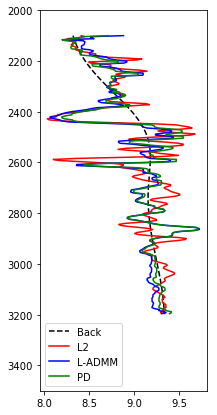

In [29]:
plt.figure(figsize=(3, 7))
plt.plot(ai_xl[nil//2], t_cut, '--k', label='Back')
plt.plot(minv[:, iilwell], t_cut, 'r', label='L2')
plt.plot(mladmm[:, nil//2], t_cut, 'b', label='L-ADMM')
plt.plot(mpd[:, nil//2], t_cut, 'g', label='PD')
plt.ylim(3500, 2000)
plt.legend();

## 2D Post-stack segmentation

Let's start by taking one of our previous inversion results and use it as input to a segmentation algorithm

In [30]:
#cl = np.log(np.array([7152, 11426, 9984, 6825, 9209, 8615])) # Ty, Shetland, CK, Draupne, Heather, Hugin
cl = np.log(np.array([7152, 13426, 9984, 6825, 9209, 8615])) # Ty, Shetland, CK, Draupne, Heather, Hugin
print(cl)
ncl = len(cl)

[8.87514732 9.5049484  9.20873909 8.82834762 9.12793655 9.06126015]


In [40]:
segpd, segpd_classes = Segment(minv, cl, 1., .1, niter=100, callback=None, 
                               simplex_engine='numba', show=False)

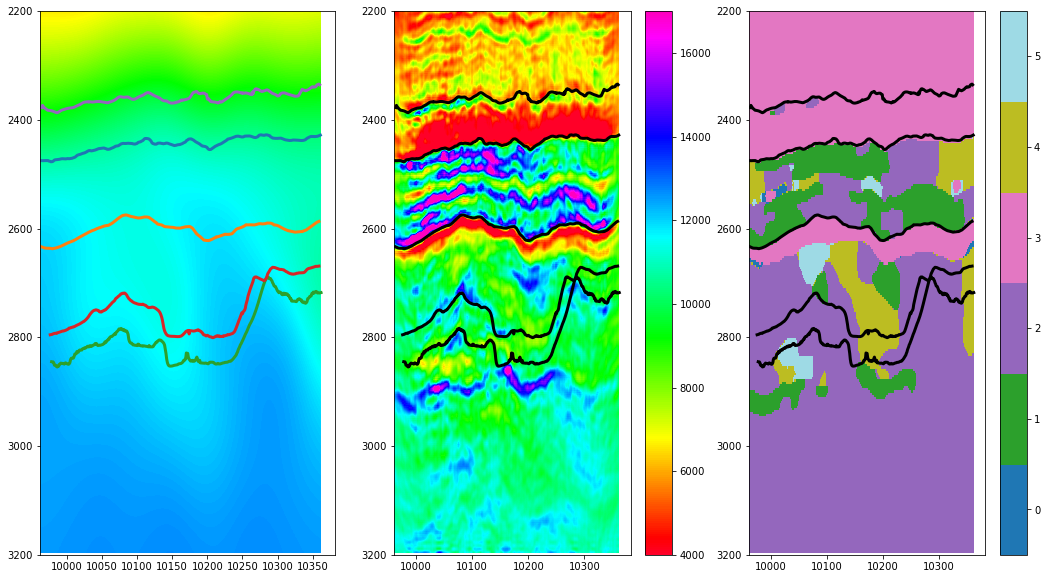

In [41]:
fig, axs = plt.subplots(1, 3, figsize=(18, 10))
axs[0].imshow(ai_xl.T, cmap='gist_rainbow', vmin=8, vmax=10, interpolation='sinc',
              extent=(il_seis[0], il_seis[-1], t_cut[-1], t_cut[0]))
for ihor, horname in enumerate(horizons_il.keys()):
    axs[0].plot(horizons_xl[horname][0], horizons_xl[horname][1], lw=3)
axs[0].axis('tight')
axs[0].set_ylim(3200,2200);
im = axs[1].imshow(np.exp(minv), cmap='gist_rainbow', vmin=4000, vmax=17000, interpolation='sinc',
              extent=(il_seis[0], il_seis[-1], t_cut[-1], t_cut[0]))
for ihor, horname in enumerate(horizons_il.keys()):
    axs[1].plot(horizons_xl[horname][0], horizons_xl[horname][1], c='k',  lw=3)
axs[1].axis('tight')
axs[1].set_ylim(3200,2200);
plt.colorbar(im, ax=axs[1])
im=axs[2].imshow(segpd_classes, cmap=cm.get_cmap('tab20', ncl), vmin=-0.5, vmax=ncl-0.5,
                 extent=(il_seis[0], il_seis[-1], t_cut[-1], t_cut[0]))
axs[2].axis('tight')
for ihor, horname in enumerate(horizons_il.keys()):
    axs[2].plot(horizons_xl[horname][0], horizons_xl[horname][1], c='k', lw=3)
axs[2].axis('tight')
axs[2].set_ylim(3200,2200)
plt.colorbar(im, ax=axs[2]);

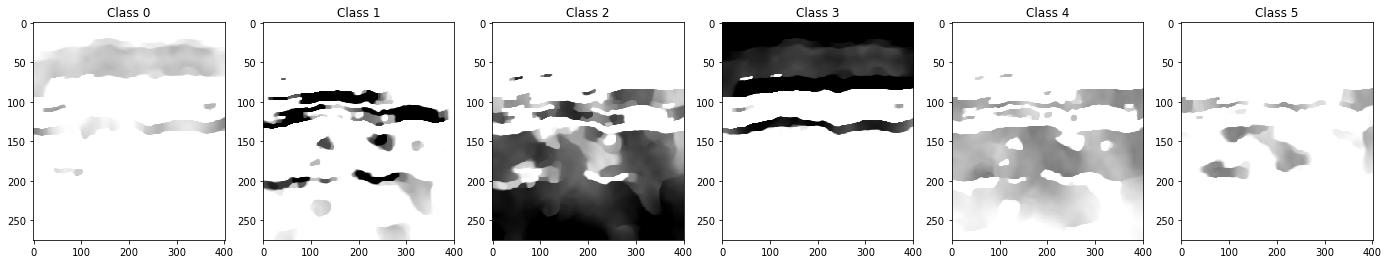

In [42]:
fig, axs = plt.subplots(1, ncl, figsize=(4*ncl, 4))
for icl in range(ncl):
    im = axs[icl].imshow(segpd[:, icl].reshape(nt, nil), cmap='gray_r', vmin=0, vmax=1)
    axs[icl].set_title('Class %d' % icl)
    axs[icl].axis('tight')

In [34]:
segpd, segpd_classes = Segment(mladmm, cl, 1., 10., niter=10, callback=None, 
                               simplex_engine='numba', show=False)

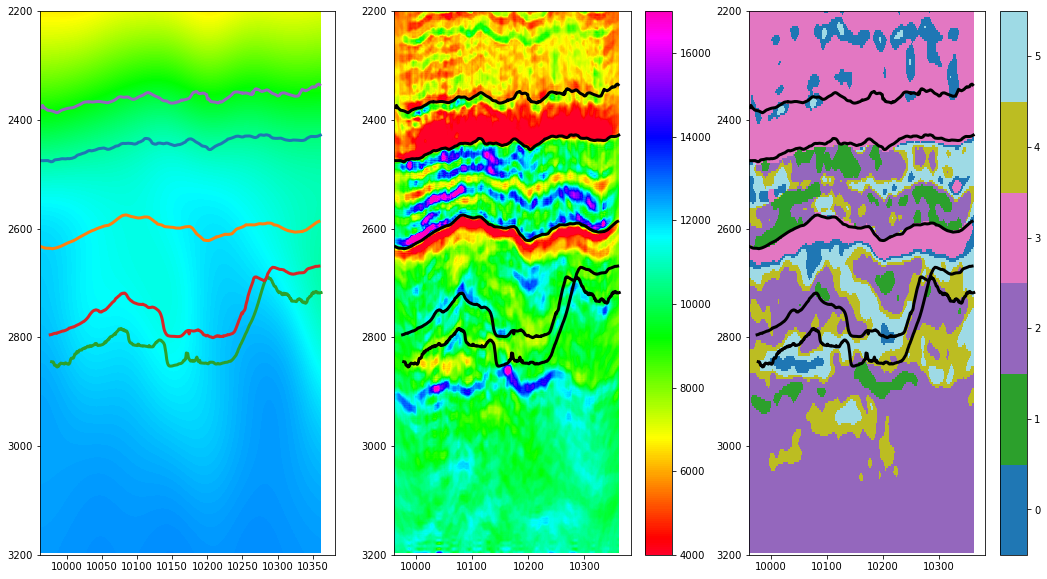

In [35]:
fig, axs = plt.subplots(1, 3, figsize=(18, 10))
axs[0].imshow(ai_xl.T, cmap='gist_rainbow', vmin=8, vmax=10, interpolation='sinc',
              extent=(il_seis[0], il_seis[-1], t_cut[-1], t_cut[0]))
for ihor, horname in enumerate(horizons_il.keys()):
    axs[0].plot(horizons_xl[horname][0], horizons_xl[horname][1], lw=3)
axs[0].axis('tight')
axs[0].set_ylim(3200,2200);
im = axs[1].imshow(np.exp(mladmm), cmap='gist_rainbow', vmin=4000, vmax=17000, interpolation='sinc',
              extent=(il_seis[0], il_seis[-1], t_cut[-1], t_cut[0]))
for ihor, horname in enumerate(horizons_il.keys()):
    axs[1].plot(horizons_xl[horname][0], horizons_xl[horname][1], c='k',  lw=3)
axs[1].axis('tight')
axs[1].set_ylim(3200,2200);
plt.colorbar(im, ax=axs[1])
im=axs[2].imshow(segpd_classes, cmap=cm.get_cmap('tab20', ncl), vmin=-0.5, vmax=ncl-0.5,
                 extent=(il_seis[0], il_seis[-1], t_cut[-1], t_cut[0]))
axs[2].axis('tight')
for ihor, horname in enumerate(horizons_il.keys()):
    axs[2].plot(horizons_xl[horname][0], horizons_xl[horname][1], c='k', lw=3)
axs[2].axis('tight')
axs[2].set_ylim(3200,2200)
plt.colorbar(im, ax=axs[2]);

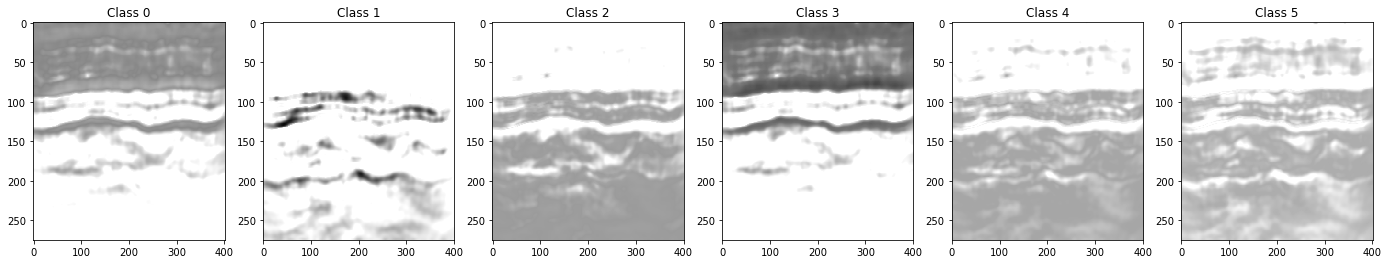

In [36]:
fig, axs = plt.subplots(1, ncl, figsize=(4*ncl, 4))
for icl in range(ncl):
    im = axs[icl].imshow(segpd[:, icl].reshape(nt, nil), cmap='gray_r', vmin=0, vmax=1)
    axs[icl].set_title('Class %d' % icl)
    axs[icl].axis('tight')

In [ ]:
segpd, segpd_classes = Segment(mpd, cl, 1., 10., niter=10, callback=None, 
                               simplex_engine='numba', show=False)

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(18, 10))
axs[0].imshow(ai_xl.T, cmap='gist_rainbow', vmin=8, vmax=10, interpolation='sinc',
              extent=(il_seis[0], il_seis[-1], t_cut[-1], t_cut[0]))
for ihor, horname in enumerate(horizons_il.keys()):
    axs[0].plot(horizons_xl[horname][0], horizons_xl[horname][1], lw=3)
axs[0].axis('tight')
axs[0].set_ylim(3200,2200);
im = axs[1].imshow(np.exp(mladmm), cmap='gist_rainbow', vmin=4000, vmax=17000, interpolation='sinc',
              extent=(il_seis[0], il_seis[-1], t_cut[-1], t_cut[0]))
for ihor, horname in enumerate(horizons_il.keys()):
    axs[1].plot(horizons_xl[horname][0], horizons_xl[horname][1], c='k',  lw=3)
axs[1].axis('tight')
axs[1].set_ylim(3200,2200);
plt.colorbar(im, ax=axs[1])
im=axs[2].imshow(segpd_classes, cmap=cm.get_cmap('tab20', ncl), vmin=-0.5, vmax=ncl-0.5,
                 extent=(il_seis[0], il_seis[-1], t_cut[-1], t_cut[0]))
axs[2].axis('tight')
for ihor, horname in enumerate(horizons_il.keys()):
    axs[2].plot(horizons_xl[horname][0], horizons_xl[horname][1], c='k', lw=3)
axs[2].axis('tight')
axs[2].set_ylim(3200,2200)
plt.colorbar(im, ax=axs[2]);

In [ ]:
fig, axs = plt.subplots(1, ncl, figsize=(4*ncl, 4))
for icl in range(ncl):
    im = axs[icl].imshow(segpd[:, icl].reshape(nt, nil), cmap='gray_r', vmin=0, vmax=1)
    axs[icl].set_title('Class %d' % icl)
    axs[icl].axis('tight')

In [39]:
np.savez('/Users/matteoravasi/Desktop/Poststack_segmentation/volve.npz', mpd=mpd, d=seismic_xl.T,
         segpd_classes=segpd_classes, segpd=segpd, cl=cl)